In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

import scipy as sci
import matplotlib
import scikit_posthocs as sci_posthocs

import analysis as ana
import plot as pl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_colwidth', None)

In [4]:
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)
font = {'family':'CMU Serif', 
               #'sans-serif':['Helvetica'],
               'size': 11}
mpl.rc('font', **font)

# Loading Data

In [5]:
# brain_data, cog_data, subj_data = ana.load_data('../data')
brain_data_z, cog_data_z, subj_data = ana.load_data('../data_zscore')
# brain_data_q, cog_data_q, subj_data = ana.load_data('../data_quant')

In [43]:
cog_data_z.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 1010 to 4024
Columns: 47 entries, sex to wasi201_iqscores_full2iq
dtypes: float64(46), int64(1)
memory usage: 58.1 KB


# all subjects

### removing multicolinearity

In [44]:
brain_data_z_m = brain_data_z.drop(['23', '24', '28'], axis=1)

In [8]:
kmo_all,kmo_model=calculate_kmo(brain_data_z_m)
kmo_model

/home/katharina/anaconda3/envs/earlypsy/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7209065758681319

In [9]:
chi_square_value,p_value=calculate_bartlett_sphericity(brain_data_z_m)
chi_square_value, p_value

(2617.1534410132995, 0.0)

In [45]:
fa = FactorAnalyzer(rotation=None)
fa.fit(brain_data_z_m)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([7.63953964, 3.12730629, 2.74919565, 2.12873605, 1.44175123,
       1.14862687, 1.02702412, 0.90177485, 0.78011183, 0.75485026,
       0.6557885 , 0.57153835, 0.52295983, 0.45907555, 0.4285171 ,
       0.38360537, 0.37497247, 0.3382909 , 0.29094758, 0.27264025,
       0.22839248, 0.19244273, 0.1676501 , 0.14434784, 0.12410247,
       0.08004035, 0.06577134])

In [46]:
# Kaiser criterion: Number eigenvalues greater than one considered as the number of factors.

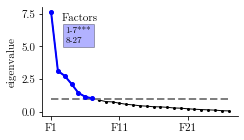

In [47]:
fig, ax = plt.subplots(figsize=(3.5,2))
feat = brain_data_z_m.shape[1]
index_significant = 6
ax.plot([f"F{i+1}" for i, v in enumerate(ev)], ev, linestyle='-', color='k', linewidth=1, marker='o', markersize=2)
ax.plot([f"F{i+1}" for i, v in enumerate(ev)], np.ones(feat), linestyle='--', color='grey', linewidth=2)
ax.plot([f"F{i+1}" for i, v in enumerate(ev)][:index_significant+1], ev[:index_significant+1], linestyle='-', color='blue', linewidth=2, marker='o', markersize=4)

ax.text(0.1, 0.95, 'Factors', transform=ax.transAxes, verticalalignment='top', weight='bold')
textstr = '\n'.join((
    '1-'+str(index_significant+1)+'***',
    str(index_significant+2) +'-'+str(feat)))
props = dict(boxstyle='square', facecolor='blue', alpha=0.3)
ax.text(0.12, 0.82, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

ax.set_ylabel('eigenvalue')
ax.set_xticks(np.arange(0,feat,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('fig/FAs_brain.svg', dpi=500, bbox_inches='tight')


In [66]:
fa = FactorAnalyzer(7, rotation=None)
fa.fit(brain_data_z_m)
loadings = fa.loadings_
brain_data_z_fa = fa.transform(brain_data_z_m)
var = fa.get_factor_variance()

In [72]:
var[-1][-1]

0.6183135073452419

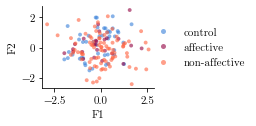

In [53]:
pl.plot_data_2D(brain_data_z_fa, FA=True)
plt.savefig('fig/brain_data2D.svg', dpi=500, bbox_inches='tight')

In [64]:
index_values = brain_data_z_m.columns
column_values = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']
loadings_df = pd.DataFrame(data = loadings, 
                  index = index_values, 
                  columns = column_values)

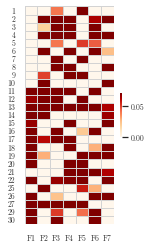

In [83]:
fig = plt.figure(figsize=(2,4))
im = sns.heatmap(loadings_df, 
                 cmap='OrRd', cbar_kws={"shrink": 0.2}, annot_kws={"fontsize":2},
                 linewidths=1,linecolor="lightgray", #annot=True,  fmt=".0",
                 vmin=0, vmax=0.07)
plt.yticks(rotation=0)
plt.savefig('fig/FA_brain_loadings.svg', dpi=500, bbox_inches='tight')
plt.show()

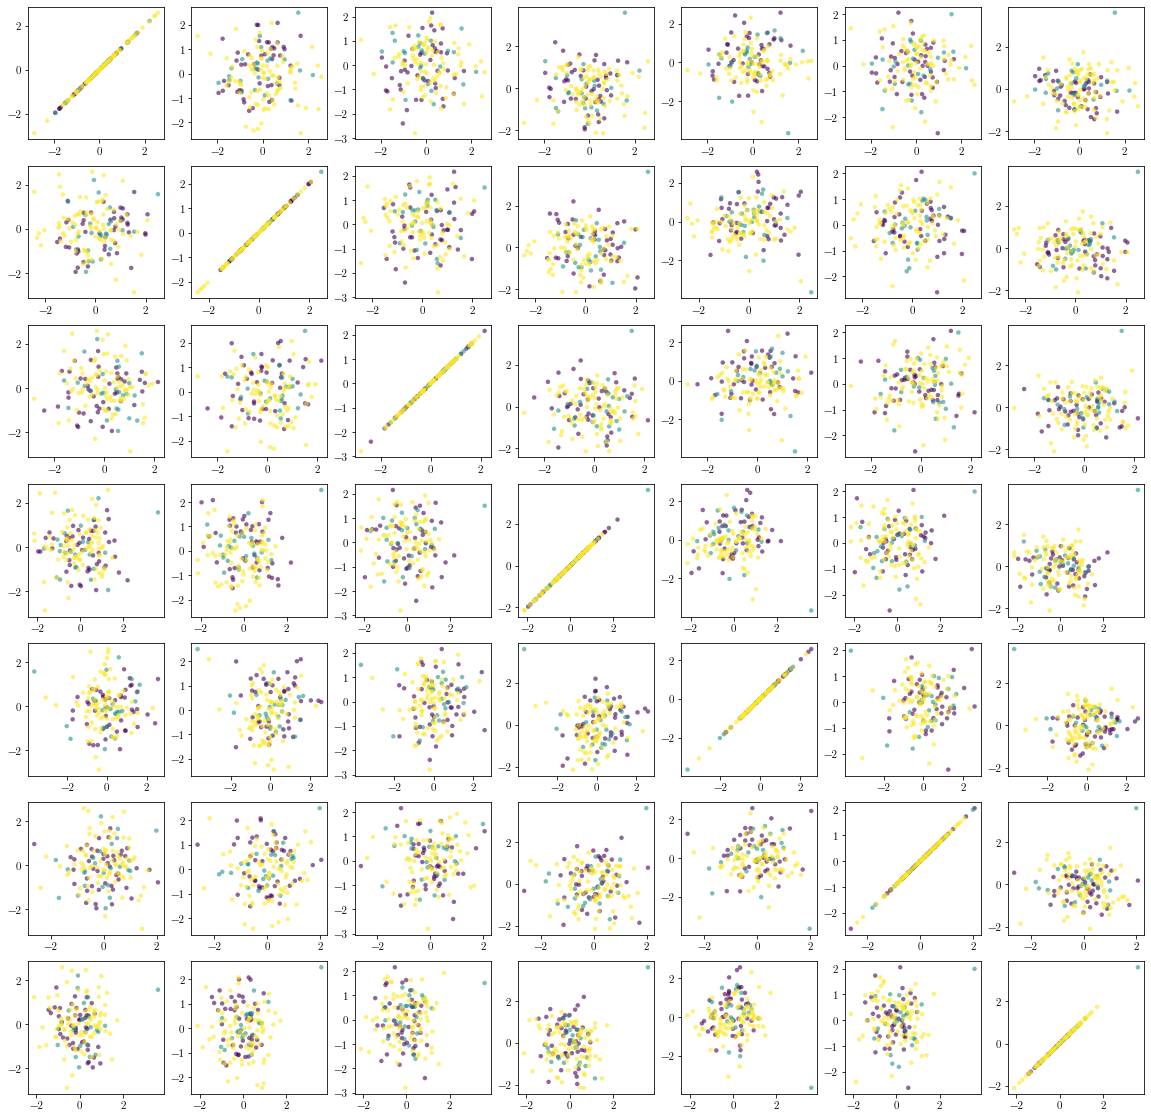

In [69]:
fig, ax = plt.subplots(7,7, figsize=(20,20))
f=0
for i in range(7):
    for j in range(7):
        ax.flatten()[f].scatter(brain_data_z_fa[:,i], brain_data_z_fa[:,j], 
                             c=subj_data['phenotype_description'], alpha=0.6, s=20, lw=0)
        f+=1

# patients only

In [6]:
# removing control
brain_data_z = brain_data_z[subj_data.phenotype != 0]
cog_data_z = cog_data_z[subj_data.phenotype != 0]
subj_data = subj_data[subj_data.phenotype != 0]

/tmp/ipykernel_77072/2427270217.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  brain_data_z = brain_data_z[subj_data.phenotype != 0]


In [7]:
subj_data['phenotype_description'].value_counts()

2    84
1    25
Name: phenotype_description, dtype: int64

In [8]:
brain_data_z_m = brain_data_z.drop(['23', '24', '28'], axis=1)

In [113]:
kmo_all,kmo_model=calculate_kmo(brain_data_z_m)
kmo_model

/home/katharina/anaconda3/envs/earlypsy/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6971978545652162

In [114]:
chi_square_value,p_value=calculate_bartlett_sphericity(brain_data_z_m)
chi_square_value, p_value

(1882.5478597369568, 1.91947783343104e-207)

In [13]:
fa = FactorAnalyzer(rotation=None)
fa.fit(brain_data_z_m)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([7.82382618, 3.19779065, 2.55993673, 2.11540679, 1.44150438,
       1.17470589, 1.10802341, 0.89976189, 0.76605672, 0.71109629,
       0.68755506, 0.59027545, 0.51041558, 0.47525882, 0.44379355,
       0.39564774, 0.3455988 , 0.301243  , 0.28130149, 0.27477039,
       0.21247742, 0.1829359 , 0.15308785, 0.13247306, 0.09372109,
       0.06453347, 0.0568024 ])

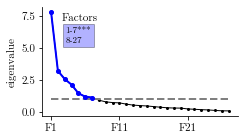

In [14]:
fig, ax = plt.subplots(figsize=(3.5,2))
feat = brain_data_z_m.shape[1]
index_significant = 6
ax.plot([f"F{i+1}" for i, v in enumerate(ev)], ev, linestyle='-', color='k', linewidth=1, marker='o', markersize=2)
ax.plot([f"F{i+1}" for i, v in enumerate(ev)], np.ones(feat), linestyle='--', color='grey', linewidth=2)
ax.plot([f"F{i+1}" for i, v in enumerate(ev)][:index_significant+1], ev[:index_significant+1], linestyle='-', color='blue', linewidth=2, marker='o', markersize=4)

ax.text(0.1, 0.95, 'Factors', transform=ax.transAxes, verticalalignment='top', weight='bold')
textstr = '\n'.join((
    '1-'+str(index_significant+1)+'***',
    str(index_significant+2) +'-'+str(feat)))
props = dict(boxstyle='square', facecolor='blue', alpha=0.3)
ax.text(0.12, 0.82, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

ax.set_ylabel('eigenvalue')
ax.set_xticks(np.arange(0,feat,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('fig/FAs_brain_pat.svg', dpi=500, bbox_inches='tight')

In [9]:
fa = FactorAnalyzer(7, rotation=None)
fa.fit(brain_data_z_m)
loadings = fa.loadings_
brain_data_z_fa = fa.transform(brain_data_z_m)
var = fa.get_factor_variance()

In [10]:
var[-1][-1]

0.6262303773108385

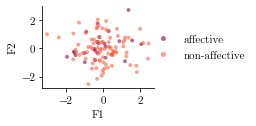

In [12]:
pl.plot_data_2D(brain_data_z_fa, True, subj_data, FA=True)
plt.savefig('fig/brain_data2D_pat.svg', dpi=500, bbox_inches='tight')

In [98]:
index_values = brain_data_z_m.columns
column_values = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']
loadings_df = pd.DataFrame(data = loadings, 
                  index = index_values, 
                  columns = column_values)

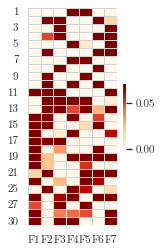

In [108]:
fig = plt.figure(figsize=(2,4))
im = sns.heatmap(loadings_df, 
                 cmap='OrRd', cbar_kws={"shrink": 0.3}, annot_kws={"fontsize":2},
                 linewidths=1,linecolor="lightgray", #annot=True,  fmt=".0",
                 vmin=0, vmax=0.07)
plt.yticks(rotation=0)
plt.savefig('fig/_FA_brain_scale_.svg', dpi=500, bbox_inches='tight')
plt.show()

In [103]:
sns.set(font_scale=1)
sns.set_style(style='white') 